# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import warnings
from scipy.optimize import fsolve
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

***

# 1. Pricing the Callable Bond

### Data

Use the data from the following files.
* `../data/callable_bonds_2025-02-13.xlsx`
* `../data/discount_curve_2025-02-13.xlsx`

The data contains info on the following bonds.

`Callable`
* `FHLMC 4.41 01/28/30` is a callable bond, and it is the primary object of our analysis.

`Reference` bonds for a forward price.
* `FHLMC 0.97 01/28/28`
* `FHLMC 1.25 01/29/30`

Though these are technically callable, they are far out of the money. Thus, for the purposes of this analysis, we consider the reference bonds as non-callable bonds.

These reference bonds are analyzed in optional problems at the end, but mostly you will focus on the `callable` bond.

In [97]:
FILE_BOND = '../data/callable_bonds_2025-02-13.xlsx'
FILE_CURVE = '../data/discount_curve_2025-02-13.xlsx'

KEY_CALLABLE = 'FHLMC 4.41 01/28/30'
KEY_REF_T1 = 'FHLMC 0.97 01/28/28'
KEY_REF_T2 = 'FHLMC 1 1/4 01/29/30'

### Bond Info

In [98]:
import pandas as pd

info = pd.read_excel(FILE_BOND,sheet_name='info').set_index('info')
info.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call"], :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,"30,000,000","25,000,000","10,000,000"
Cpn Rate,0.97%,1.25%,4.41%
Cpn Freq,2,2,2
Date Quoted,2025-02-13,2025-02-13,2025-02-13
Date Issued,2020-10-28,2020-07-29,2025-01-28


### Quoted Values

In [99]:
quotes = pd.read_excel(FILE_BOND,sheet_name='quotes').set_index('quotes')
quotes.style.format('{:.2f}', subset=pd.IndexSlice[quotes.index[1:], :]).format('{:%Y-%m-%d}', subset=pd.IndexSlice['Date Quoted', :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13,2025-02-13,2025-02-13
TTM,2.95,4.96,4.96
Clean Price,90.14,85.11,99.89
Dirty Price,90.19,85.16,100.09
Accrued Interest,0.04,0.05,0.20
YTM Call,54.24,85.40,4.45
YTM Maturity,4.57,4.65,4.43
Duration,2.92,4.81,4.50
Modified Duration,2.85,4.70,4.40


### Discount Curves

In [100]:
discs = pd.read_excel(FILE_CURVE,sheet_name='discount curve').set_index('ttm')
display(discs.head())
display(discs.tail())

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043743,0.978597
1.0,2026-02-13,0.042890,0.958451
1.5,2026-08-13,0.042238,0.939228
2.0,2027-02-13,0.041843,0.920515
2.5,2027-08-13,0.041632,0.902117


,maturity date,spot rate,discount
ttm,,,
28.0,2053-02-13,0.040185,0.328231
28.5,2053-08-13,0.040051,0.322978
29.0,2054-02-13,0.039916,0.317851
29.5,2054-08-13,0.039791,0.312766
30.0,2055-02-13,0.039665,0.307802


***

### 1.1.

Use the discount curve data to price both the `callable` and `reference` bonds.

For now, calculate the price of the `callable` bond as if it were non-callable. We refer to this as the `hypothetical` bond.

In [101]:
def CF_matrix(df):
    lst = []

    for i in df.columns:
        cpn_dates = pd.DataFrame(get_coupon_dates(df.loc["Date Quoted", i], df.loc["Date Matures", i]))
        cpn_dates.columns = ["CPN Date"]
        cpn_dates[i] = 0

        for j in range(len(cpn_dates)):
            cpn_dates[i][j] = df.loc["Cpn Rate", i]/2

        cpn_dates[i][len(cpn_dates)-1] += 100
        cpn_dates = cpn_dates.set_index("CPN Date")
        cpn_dates = cpn_dates.T

        lst.append(cpn_dates)

    df = pd.concat(lst).fillna(0)
    df = df.loc[:, df.sum(axis=0) != 0]

    return df

In [102]:
info.loc["Cpn Rate"] = info.loc["Cpn Rate"] * 100
CF = CF_matrix(info)
CF.columns = CF.columns - info.loc["Date Quoted", "FHLMC 0.97 01/28/28"]
CF.columns = CF.columns.days/365.25
CF

CPN Date,0.451745,0.454483,0.955510,0.958248,1.451061,1.453799,1.954825,1.957563,2.450376,2.453114,2.954141,2.956879,3.452430,3.455168,3.956194,3.958932,4.451745,4.454483,4.955510,4.958248
FHLMC 0.97 01/28/28,0.485,0.000,0.485,0.000,0.485,0.000,0.485,0.000,0.485,0.000,100.485,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
FHLMC 1 1/4 01/29/30,0.000,0.625,0.000,0.625,0.000,0.625,0.000,0.625,0.000,0.625,0.000,0.625,0.000,0.625,0.000,0.625,0.000,0.625,0.000,100.625
FHLMC 4.41 01/28/30,2.205,0.000,2.205,0.000,2.205,0.000,2.205,0.000,2.205,0.000,2.205,0.000,2.205,0.000,2.205,0.000,2.205,0.000,102.205,0.000


In [103]:
ps = []

for i in CF.index:
    p = 0
    
    for j in CF.columns.values:
        Z = np.interp(j, discs.index, discs["discount"])
        PV = Z * CF.loc[i,j]
        p += PV
    
    ps.append(p)

In [104]:
price = pd.DataFrame({"Bond": CF.index, "Hypothetical P": ps}).set_index("Bond")
price

,Hypothetical P
Bond,
FHLMC 0.97 01/28/28,91.285844
FHLMC 1 1/4 01/29/30,87.243000
FHLMC 4.41 01/28/30,101.410165


### 1.2.

Calculate the forward price of the `hypothetical` bond as of the date that the `callable` bond can be exercised.

Use the information from the discount curve (and associated forward curve) to calculate this forward price.

In [105]:
price["T-t"] = pd.to_datetime(info.loc["Date Next Call"]) - pd.to_datetime(info.loc["Date Quoted"])
price["T-t"] = price["T-t"].dt.days / 365.25

fps = []

for i in CF.index:
    p = 0
    Zo = np.interp(price["T-t"][i], discs.index, discs["discount"])
    
    for j in CF.columns.values:
        if j > price.loc[i, "T-t"]:
            Z = np.interp(j, discs.index, discs["discount"])
            PV = Z * CF.loc[i,j]
            p += PV
    
    fps.append(p/Zo)

price["Forward P"] = fps
price

,Hypothetical P,T-t,Forward P
Bond,,,
FHLMC 0.97 01/28/28,91.285844,0.202601,93.282412
FHLMC 1 1/4 01/29/30,87.243000,0.205339,89.151145
FHLMC 4.41 01/28/30,101.410165,2.954141,100.571684


### 1.3.

The provided implied vol corresponds to the implied vol of the **rate**. Specifically,
* the forward rate corresponding to the time of expiration.
* continuously compounded.

Use the duration approximation to get the approximate implied vol corresponding to the forward price.

$$\sigma_{\text{bond fwd price}} \approx D \times \sigma_{\text{fwd rate}}\times f(T_1)$$

where $f(T_1)$ is the continuously-compounded (instantaneous) forward rate at time $T_1$.
* If you're struggling with the forward rate calc, just usse the provided spot rate at $T_1$; it will be a close approximation in this example.
* In this approximation, use the quoted duration from the table. (Yes, this is a bit circular, but we don't want to get bogged down with a duration calculation at this point.)

Report the implied vol of the bond's forward price.

In [106]:
price["IV rate"] = quotes.loc["Implied Vol"]/100

ds = []

for i in CF.index:
    d = 0
    
    for j in CF.columns.values:
        Z = np.interp(j, discs.index, discs["discount"])
        w = Z * CF.loc[i,j]/price.loc[i, "Hypothetical P"]
        d += w * j
    
    ds.append(d)

price["Duration"] = ds
price["Forward Rate"] = -np.log(np.interp(price["T-t"], discs.index, discs["discount"]))
price["IV"] = price["Duration"] * price["Forward Rate"] * price["IV rate"]
price

,Hypothetical P,T-t,Forward P,IV rate,Duration,Forward Rate,IV
Bond,,,,,,,
FHLMC 0.97 01/28/28,91.285844,0.202601,93.282412,0.19599,2.916103,0.021636,0.012365
FHLMC 1 1/4 01/29/30,87.243000,0.205339,89.151145,0.210934,4.808354,0.021636,0.021944
FHLMC 4.41 01/28/30,101.410165,2.954141,100.571684,0.238798,4.500521,0.121334,0.1304


In [107]:
price = price[["Hypothetical P", "Duration", "T-t", "Forward P", "IV"]]
price

,Hypothetical P,Duration,T-t,Forward P,IV
Bond,,,,,
FHLMC 0.97 01/28/28,91.285844,2.916103,0.202601,93.282412,0.012365
FHLMC 1 1/4 01/29/30,87.243000,4.808354,0.205339,89.151145,0.021944
FHLMC 4.41 01/28/30,101.410165,4.500521,2.954141,100.571684,0.1304


### 1.4.

For the `callable` bond, report Black's value of the embedded call option.
* Use this to report the value of the `callable` bond.
* How does it compare to the actual market price?

For the calculation of the option, use...
* the quoted `Implied Vol` calculated above.
* forward price of the `hypothetical` bond calculated above.
* provided discount factor

#### Simplifications
Note that in this calculation we are making a few simplifications.
* We are simplifying that the `callable` bond is European exercise with an exercise date as reported in `Date Next Call` above. 
* In reality, it is Bermudan, with quarterly exercise dates after the first exercise date.
* The time-to-exercise is not a round number, but you only have discount factors at rounded time-to-maturities. Just use the closest discount factor.

In [108]:
from scipy.stats import norm

def Black76(Z, forward, strike, vol, time, call=True):
    d1 = (np.log(forward / strike) - (vol ** 2) / 2 * time) / (np.sqrt(time) * vol)
    d2 = d1 - np.sqrt(time) * vol

    if call:
        p = Z * (forward * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        p = Z * (strike * norm.cdf(-d2) - forward * norm.cdf(-d1))

    return p

In [109]:
price["Call"] = 0

for i in range(len(price)):
    Z = np.interp(price["T-t"].iloc[i], discs.index, discs["discount"])
    price["Call"].iloc[i] = Black76(Z, price["Forward P"].iloc[i], 100, price["IV"].iloc[i], price["T-t"].iloc[i], call=True)
    
price["Callable Bond"] = price["Hypothetical P"] - price["Call"]
price

,Hypothetical P,Duration,T-t,Forward P,IV,Call,Callable Bond
Bond,,,,,,,
FHLMC 0.97 01/28/28,91.285844,2.916103,0.202601,93.282412,0.012365,1.673939e-37,91.285844
FHLMC 1 1/4 01/29/30,87.243000,4.808354,0.205339,89.151145,0.021944,2.922877e-32,87.243000
FHLMC 4.41 01/28/30,101.410165,4.500521,2.954141,100.571684,0.1304,7.985008e+00,93.425158


**The callable bond price ($93.43) is less than the market price ($99.89) . This could imply the market is pricing in factors like higher expected vol, different interest rate outlook, or other features we haven't captured.**

### 1.5.

Calculate the YTM of the callable bond, assuming that...
* it can never be called. (This is the `hypothetical` bond we analyzed above.)
* it will certainly be called.

How do these compare to the quoted YTM Called and YTM Maturity in the table?

In [110]:
from scipy.optimize import newton

def bond_price(ytm, cash_flows, times):
    return sum(cf / (1 + ytm) ** t for cf, t in zip(cash_flows, times))

def ytm_solver(bond, price):
    func = lambda ytm: bond_price(ytm, CF.loc[bond], CF.columns.values) - price
    return newton(func, 0.05)

In [111]:
ys = []

for i in CF.index:
    y = ytm_solver(i, price.loc[i, "Hypothetical P"])
    ys.append(y)

price["YTM"] = ys
price

,Hypothetical P,Duration,T-t,Forward P,IV,Call,Callable Bond,YTM
Bond,,,,,,,,
FHLMC 0.97 01/28/28,91.285844,2.916103,0.202601,93.282412,0.012365,1.673939e-37,91.285844,0.041940
FHLMC 1 1/4 01/29/30,87.243000,4.808354,0.205339,89.151145,0.021944,2.922877e-32,87.243000,0.041764
FHLMC 4.41 01/28/30,101.410165,4.500521,2.954141,100.571684,0.1304,7.985008e+00,93.425158,0.041793


**The YTM we calculated (4.2%) are less than the YTM in the quoted table (4.4%). This indicates that we are undervaluing the yield compared to market expectations. Again, this may be due to market assumptions being different from ours.**

### 1.6.

Calculate the duration of...
* the `hypothetical` bond
* the `callable` bond

How do these compare to the quoted duration in the table?

For the callable bond, calculate duration numerically by modifying the spot rates up and down by 1bp and seeing how it changes the valuation of parts `1.1`-`1.3`.

In [112]:
price

,Hypothetical P,Duration,T-t,Forward P,IV,Call,Callable Bond,YTM
Bond,,,,,,,,
FHLMC 0.97 01/28/28,91.285844,2.916103,0.202601,93.282412,0.012365,1.673939e-37,91.285844,0.041940
FHLMC 1 1/4 01/29/30,87.243000,4.808354,0.205339,89.151145,0.021944,2.922877e-32,87.243000,0.041764
FHLMC 4.41 01/28/30,101.410165,4.500521,2.954141,100.571684,0.1304,7.985008e+00,93.425158,0.041793


In [113]:
discs.head()

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043743,0.978597
1.0,2026-02-13,0.042890,0.958451
1.5,2026-08-13,0.042238,0.939228
2.0,2027-02-13,0.041843,0.920515
2.5,2027-08-13,0.041632,0.902117


In [114]:
up_1 = discs.copy()
up_1["spot rate"] = up_1["spot rate"] + 0.0001
up_1["discount"] = 1 / (1 + up_1["spot rate"]/2) ** (2 * up_1.index)
up_1.head()

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043843,0.978549
1.0,2026-02-13,0.042990,0.958357
1.5,2026-08-13,0.042338,0.939090
2.0,2027-02-13,0.041943,0.920335
2.5,2027-08-13,0.041732,0.901896


In [115]:
down_1 = discs.copy()
down_1["spot rate"] = down_1["spot rate"] - 0.0001
down_1["discount"] = 1 / (1 + down_1["spot rate"]/2) ** (2 * down_1.index)
down_1.head()

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043643,0.978644
1.0,2026-02-13,0.042790,0.958545
1.5,2026-08-13,0.042138,0.939366
2.0,2027-02-13,0.041743,0.920696
2.5,2027-08-13,0.041532,0.902338


In [116]:
def callable_bond(info, disc):
    CF = CF_matrix(info)
    CF.columns = CF.columns - info.loc["Date Quoted", "FHLMC 0.97 01/28/28"]
    CF.columns = CF.columns.days/365.25
    
    ps = []

    for i in CF.index:
        p = 0

        for j in CF.columns.values:
            Z = np.interp(j, disc.index, disc["discount"])
            PV = Z * CF.loc[i,j]
            p += PV

        ps.append(p)
    
    price = pd.DataFrame({"Bond": CF.index, "Hypothetical P": ps}).set_index("Bond")
    
    price["T-t"] = pd.to_datetime(info.loc["Date Next Call"]) - pd.to_datetime(info.loc["Date Quoted"])
    price["T-t"] = price["T-t"].dt.days / 365.25
    
    fps = []

    for i in CF.index:
        p = 0
        Zo = np.interp(price["T-t"][i], discs.index, discs["discount"])

        for j in CF.columns.values:
            if j > price.loc[i, "T-t"]:
                Z = np.interp(j, discs.index, discs["discount"])
                PV = Z * CF.loc[i,j]
                p += PV

        fps.append(p/Zo)

    price["Forward P"] = fps
    
    price["IV rate"] = quotes.loc["Implied Vol"]/100

    ds = []

    for i in CF.index:
        d = 0

        for j in CF.columns.values:
            Z = np.interp(j, disc.index, disc["discount"])
            w = Z * CF.loc[i,j]/price.loc[i, "Hypothetical P"]
            d += w * j

        ds.append(d)

    price["Duration"] = ds
    price["Forward Rate"] = -np.log(np.interp(price["T-t"], disc.index, disc["discount"]))
    price["IV"] = price["Duration"] * price["Forward Rate"] * price["IV rate"]
    
    price["Call"] = 0

    for i in range(len(price)):
        Z = np.interp(price["T-t"].iloc[i], disc.index, disc["discount"])
        price["Call"].iloc[i] = Black76(Z, price["Forward P"].iloc[i], 100, price["IV"].iloc[i], price["T-t"].iloc[i], call=True)
    
    price["Callable Bond"] = price["Hypothetical P"] - price["Call"]
    
    return price[["Callable Bond"]]   

In [117]:
def callable_bond_specific(info, discs, bond):
    df = callable_bond(info, discs)
    return float(df.loc[bond, "Callable Bond"])

In [118]:
P0 = callable_bond(info, discs)

Pd = callable_bond(info, down_1)
Pd.columns = ["P 1bp down"]

Pu = callable_bond(info, up_1)
Pu.columns = ["P 1bp up"]

d = P0.join(Pd).join(Pu)
d["Effective Duration"] = (d["P 1bp down"] - d["P 1bp up"])/d["Callable Bond"]/0.0002
d

,Callable Bond,P 1bp down,P 1bp up,Effective Duration
Bond,,,,
FHLMC 0.97 01/28/28,91.285844,91.311921,91.259775,2.856226
FHLMC 1 1/4 01/29/30,87.243000,87.284107,87.201915,4.710528
FHLMC 4.41 01/28/30,93.425158,93.484812,93.365544,6.383028


In [119]:
d["Hypothetical Duration"] = price["Duration"]
d["Callable Bond Duration"] = d["Effective Duration"]
d["Quoted Duration"] = quotes.loc["Duration"]

d[["Hypothetical Duration", "Callable Bond Duration", "Quoted Duration"]]

,Hypothetical Duration,Callable Bond Duration,Quoted Duration
Bond,,,
FHLMC 0.97 01/28/28,2.916103,2.856226,2.917203
FHLMC 1 1/4 01/29/30,4.808354,4.710528,4.806058
FHLMC 4.41 01/28/30,4.500521,6.383028,4.496738


**The hypothetical bond has a similar duration (~4.5) to the quoted duration (~4.5), while the callable bond has quite a higher duration (6.4). This is interesting, as usualyl we would expect the duration to be lower. However, this might be feasible if interest rates are high and we are far out of the money.**

### 1.7.

Calculate the OAS of the `callable` bond.

How does it compare to the quoted OAS?

Recall that the OAS is the parallel shift in the spot curve needed to align the modeled value to the market quote.

In [120]:
pdiff = price[["Callable Bond"]]
pdiff["Market Price"] = quotes.loc["Dirty Price"]

pdiff

,Callable Bond,Market Price
Bond,,
FHLMC 0.97 01/28/28,91.285844,90.187111
FHLMC 1 1/4 01/29/30,87.243000,85.161583
FHLMC 4.41 01/28/30,93.425158,100.089


In [121]:
def shift_yield_curve(discs, change):
    up_1 = discs.copy()
    up_1["spot rate"] = up_1["spot rate"] + change/10000
    up_1["discount"] = 1 / (1 + up_1["spot rate"]/2) ** (2 * up_1.index)
    
    return up_1

In [122]:
callable_bond_specific(info, discs, "FHLMC 0.97 01/28/28")

91.28584355880491

In [123]:
#Asked ChatGPT to generate an OAS function 

def calc_oas(info, discs, bond_name, market_price, tol=1e-6, max_iter=100, initial_guess=0.0):    
    def shift_yield_curve(discs, change_bps):
        up_1 = discs.copy()
        up_1["spot rate"] = up_1["spot rate"] + change_bps / 10000.0
        up_1["discount"] = 1 / (1 + up_1["spot rate"] / 2) ** (2 * up_1.index)
        return up_1

    def price_given_spread(spread_bps):
        shifted_curve = shift_yield_curve(discs, spread_bps)
        return callable_bond_specific(info, shifted_curve, bond_name)

    oas = initial_guess
    eps = 1e-4

    def f(spread_bps):
        return price_given_spread(spread_bps) - market_price

    for _ in range(max_iter):
        fx = f(oas)

        if abs(fx) < tol:
            return oas

        fx_up = f(oas + eps)
        fprime = (fx_up - fx) / eps

        if abs(fprime) < 1e-12:
            raise RuntimeError("Derivative too small; Newton's method may fail to converge.")

        oas -= fx / fprime

    raise RuntimeError("Newton's method did not converge within max_iter iterations.")


In [124]:
oas = []

for i in pdiff.index:
    oas.append(calc_oas(info, discs, i, pdiff.loc[i, "Market Price"]))

pdiff["OAS"] = oas
pdiff["Quoted OAS"] = quotes.loc["OAS Spread"]
pdiff

,Callable Bond,Market Price,OAS,Quoted OAS
Bond,,,,
FHLMC 0.97 01/28/28,91.285844,90.187111,42.442517,25.829994
FHLMC 1 1/4 01/29/30,87.243000,85.161583,51.338842,25.969759
FHLMC 4.41 01/28/30,93.425158,100.089,-107.715988,-26.768085


**Our model has significantly lower OAS (-108) than the quoted amounts (-27),suggesting that our model believes a much larger downward shift in the yield curve is required to align our valuation with market price.**

### 1.8. Optional

Calculate the forward price of the `hypothetical` bond, but try doing so by using the `reference` bonds to calculate the forward price.
* The prices of these reference bonds would be discount factors, and we simply take the ratio.
* However, the coupons of the bonds do not align, so you need to adjust for this fact.

### 1.9. Optional

Analyze what we have called the `reference` bonds as `callable` bonds. 

Calculate its value, YTMs, duration, and OAS.

***

# 2. Pricing Floors

### Data

The file `data/cap_curves_2025-01-31.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.

In [125]:
capc = pd.read_excel("..\data\cap_curves_2025-01-31.xlsx").set_index("tenor")
capc.head()

,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,,
0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN
0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500
0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478
1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562
1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138


### 2.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency

In [126]:
capc.loc[2.75]

swap rates    0.039631
spot rates    0.039603
discounts     0.897294
forwards      0.039572
flat vols     0.230349
fwd vols      0.260092
Name: 2.75, dtype: float64

In [127]:
Z = 1 / (1 + capc.loc[3, "spot rates"]/4) ** 12
100 * Black76(Z, capc.loc[3, "forwards"], capc.loc[3, "swap rates"], capc.loc[3, "fwd vols"], 2.75, False)

0.5321909759915971

### 2.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.

In [128]:
p0 = 0

for i in np.arange(0.5, 3, 0.25):
    Z = 1 / (1 + capc.loc[i, "spot rates"]/4) ** (i * 4)
    p0 += 100 * Black76(Z, capc.loc[i, "forwards"], capc.loc[3, "swap rates"], capc.loc[3, "flat vols"], i - 0.25, False)

p0

3.8497602020954886

***

# 3. Stripping Caps

### Data

Continue with the file `data/cap_curves_2025-01-31.xlsx`.

### 3.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [129]:
ps = []

for i in np.arange(0.5, 10.25, 0.25):
    K = capc.loc[i, "swap rates"]
    vol = capc.loc[i, "flat vols"]
    p = 0
    
    for j in np.arange(0.5, i+0.25, 0.25):
        Z = 1 / (1 + capc.loc[i, "spot rates"]/4) ** (i * 4)
        p += Black76(Z, capc.loc[i, "forwards"], K, vol, i-0.25)
    
    ps.append(p)

Caps = pd.DataFrame({"Maturity": np.arange(0.5, 10.25, 0.25), "Cap Price": ps}).set_index("Maturity")
Caps

,Cap Price
Maturity,
0.50,0.000606
0.75,0.001818
1.00,0.003803
1.25,0.005589
1.50,0.011106
1.75,0.017719
2.00,0.025803
2.25,0.028151
2.50,0.037620


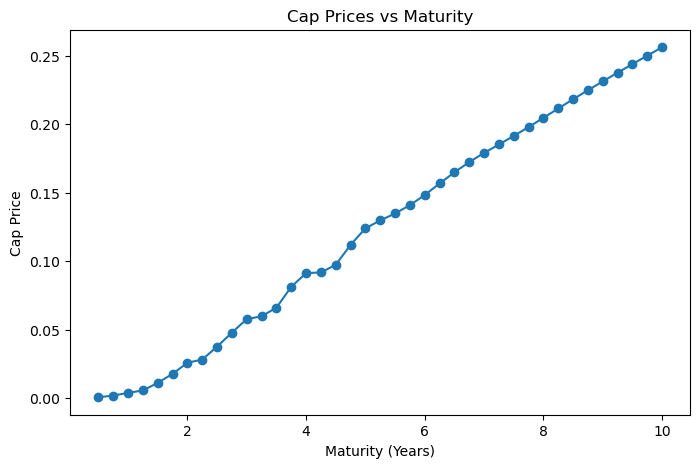

In [130]:
plt.figure(figsize=(8,5))
plt.plot(Caps.index, Caps["Cap Price"], marker='o')
plt.xlabel("Maturity (Years)")
plt.ylabel("Cap Price")
plt.title("Cap Prices vs Maturity")
plt.show()

### 3.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

In [131]:
Caps["Caplet"] = Caps["Cap Price"].diff()
Caps["Caplet"].iloc[0] = Caps["Cap Price"].iloc[0]
Caps

,Cap Price,Caplet
Maturity,,
0.50,0.000606,0.000606
0.75,0.001818,0.001212
1.00,0.003803,0.001985
1.25,0.005589,0.001786
1.50,0.011106,0.005517
1.75,0.017719,0.006613
2.00,0.025803,0.008084
2.25,0.028151,0.002349
2.50,0.037620,0.009469


In [132]:
#Asked ChatGPT to give me a function that backs out implied vol from the price

import numpy as np
from scipy.optimize import newton, minimize_scalar

def implied_vol_black76(price_market, Z, F, K, T, initial_guess=0.2, tol=1e-6, max_iter=100):
    def objective(vol):
        return Black76(Z, F, K, vol, T) - price_market
    
    def derivative(vol):
        d1 = (np.log(F / K) + (vol**2 / 2) * T) / (vol * np.sqrt(T))
        vega = F * np.sqrt(T) * np.exp(-0.5 * d1**2) / np.sqrt(2 * np.pi)
        return max(vega, 1e-12)  # Avoid division by zero
    
    try:
        # Try Newton's method first
        vol_implied = newton(objective, initial_guess, fprime=derivative, tol=tol, maxiter=max_iter)
        
        if vol_implied < 0 or np.isnan(vol_implied):
            raise RuntimeError("Invalid implied vol")
    except (RuntimeError, ValueError, FloatingPointError):
        # Fallback: Use a scalar minimization approach
        result = minimize_scalar(lambda vol: abs(objective(vol)), bounds=(0.0001, 2.0), method='bounded')
        vol_implied = result.x if result.success else np.nan
    
    return vol_implied


In [133]:
ss = []

for i in np.arange(0.5, 10.25, 0.25):
    K = capc.loc[i, "swap rates"]
    vol = capc.loc[i, "flat vols"]
    F = capc.loc[i, "forwards"]
    price_market = Caps.loc[i, "Caplet"]
    Z = 1 / (1 + capc.loc[i, "spot rates"]/4) ** (i * 4)
    T = i - 0.25
    
    s = implied_vol_black76(price_market, Z, F, K, T)
    ss.append(s)

In [134]:
Caps["Forward Vol"] = ss
Caps["Flat Vol"] = capc.loc[np.arange(0.5, 10.25, 0.25), "flat vols"]
Caps

,Cap Price,Caplet,Forward Vol,Flat Vol
Maturity,,,,
0.50,0.000606,0.000606,0.101500,0.101500
0.75,0.001818,0.001212,0.145214,0.116946
1.00,0.003803,0.001985,0.188775,0.132391
1.25,0.005589,0.001786,0.188513,0.159421
1.50,0.011106,0.005517,0.425723,0.180856
1.75,0.017719,0.006613,0.470007,0.197446
2.00,0.025803,0.008084,0.580609,0.209941
2.25,0.028151,0.002349,0.153106,0.219090
2.50,0.037620,0.009469,0.706294,0.225643


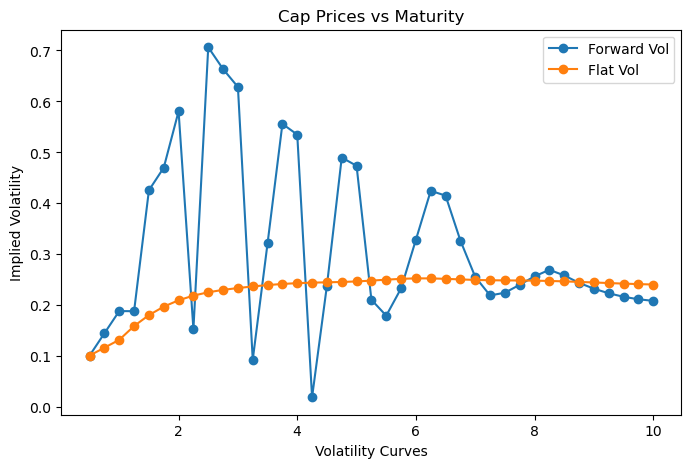

In [135]:
plt.figure(figsize=(8,5))
plt.plot(Caps.index, Caps["Forward Vol"], marker='o', label = "Forward Vol")
plt.plot(Caps.index, Caps["Flat Vol"], marker='o', label = "Flat Vol")
plt.xlabel("Volatility Curves")
plt.ylabel("Implied Volatility")
plt.title("Cap Prices vs Maturity")
plt.legend()
plt.show()

***